In [1]:
import numpy as np
from PIL import Image

from astropy.io import fits
import matplotlib.pyplot as plt

In [28]:
# small_circle = Image.open('gal_pngs/smallcircle.png')
# elliptical = Image.open('gal_pngs/elliptical.png')
# source = Image.open('gal_pngs/source.png')

# numpydata1 = np.asarray(small_circle)
# numpydata2 = np.asarray(elliptical)
# numpydata3 = np.asarray(source)

# print(type(numpydata))

In [29]:
# https://photutils.readthedocs.io/en/stable/segmentation.html following these helpful docs

In [2]:
img = 'rsb_fits_images/test.fits'
data = fits.getdata(img)
header = fits.getheader(img)
bgvar = header['BGVAR']
bgmean = header['BGMEAN']
# plt.hist(data.flatten(), bins=100, range=[-5,2200]);
# plt.yscale('log');

In [3]:
# create segmentation map from fits image
data -= bgmean
# plt.hist(data.flatten(), bins=100, range=[-5,2200]);
# plt.yscale('log');
# already background subtracted?

In [4]:
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
img_data = data
bkg = Background2D(img_data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
img_data -= bkg.background

In [5]:
# plt.hist(img_data.flatten(), bins=100, range=[-1,1]);
# very different... normalized to 1

In [6]:
threshold = 1.9 * bkg.background_rms
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(img_data, kernel)

In [7]:
# plt.hist(convolved_data.flatten(), bins=100, range=[-1,1]);

(4200, 4200)


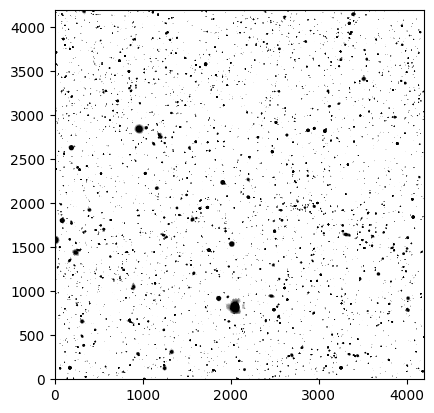

In [8]:
from photutils.segmentation import detect_sources
from matplotlib.colors import LogNorm

segment_map = detect_sources(convolved_data, threshold, npixels=10)
%matplotlib inline
print(segment_map.shape)
plt.imshow(img_data, cmap='gray_r', norm=LogNorm(vmin=0.1, vmax=1),origin='lower')

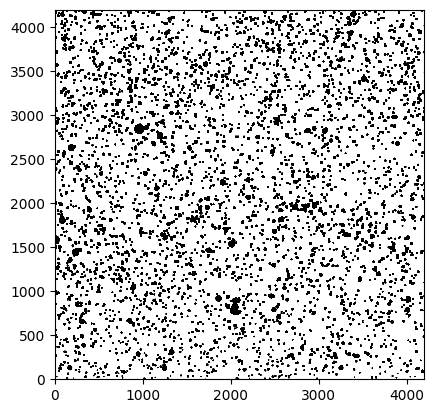

In [9]:
plt.imshow(segment_map, cmap='gray_r', norm=LogNorm(vmin=0.1, vmax=1), origin='lower')
# seems to be an okay seg...

Text(0.5, 1.0, 'Segmentation Image')

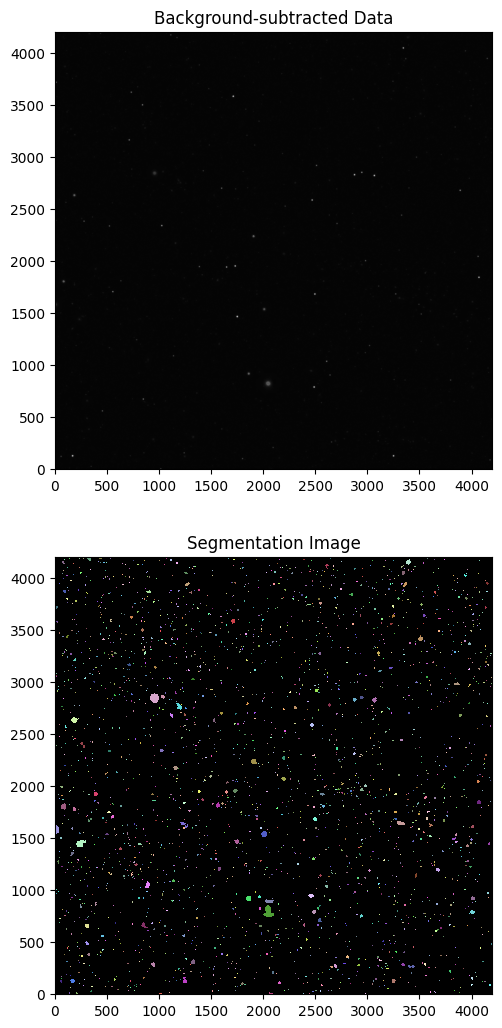

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')

In [11]:
# get bounding boxes of sources
segment_map.remove_border_labels(10, partial_overlap=False, relabel=False)
bbox = segment_map.bbox
print(len(bbox))
shortened_bbox = bbox[500:3500:30]
print(len(shortened_bbox))
print(shortened_bbox[0])
print(shortened_bbox[0].center)
# print(shortened_bbox)

4097
100
BoundingBox(ixmin=2108, ixmax=2125, iymin=559, iymax=575)
(566.5, 2116.0)


In [13]:
from astropy import nddata
# create cutouts!!
# following these docs: https://docs.astropy.org/en/stable/api/astropy.nddata.Cutout2D.html

In [14]:
# ixmin, ixmax, iymin, iymax
cutouts = []
for i in range(len(shortened_bbox)):
    y_center, x_center = shortened_bbox[i].center
    x_len,y_len = shortened_bbox[i].shape
    min_length = 12
    if (x_len> 10 and y_len > 10 and x_len < 40 and y_len < 40):
        length = max([x_len, y_len, min_length]) * 1.25
        my_cutout = nddata.Cutout2D(img_data, (x_center,y_center), int(length))
        cutouts.append(my_cutout)
# cutouts = []
# for i in range(len(shortened_bbox)):
#     ixmin,  ixmax, iymin, iymax = shortened_bbox[i].ixmin, shortened_bbox[i].ixmax, shortened_bbox[i].iymin, shortened_bbox[i].iymax
#     x_avg = (ixmin + ixmax)/2
#     y_avg = (iymin + iymax)/2
#     x_dist = abs(ixmax-ixmin)
#     y_dist = abs(iymax-iymin)
#     if (x_dist> 8 and y_dist > 8):
#         my_cutout = nddata.Cutout2D(img_data, (x_avg,y_avg), (x_dist,y_dist)) # cutout takes center coordiante and expands from there given distances
#         cutouts.append(my_cutout)
# # how to handle if they are on the border  --> remove_border_labels(10, partial_overlap=False, relabel=False)

In [15]:
for j in cutouts:
    print(j.shape)

(21, 21)
(27, 27)
(15, 15)
(16, 16)
(16, 16)
(15, 15)
(23, 23)
(23, 23)
(21, 21)
(25, 25)
(26, 26)
(15, 15)
(27, 27)
(25, 25)
(17, 17)
(15, 15)
(15, 15)
(22, 22)
(20, 20)
(21, 21)
(18, 18)
(18, 18)
(21, 21)
(22, 22)
(15, 15)
(15, 15)
(33, 33)
(20, 20)
(21, 21)
(23, 23)


Text(0.5, 1.0, 'Attempt of cuttout image')

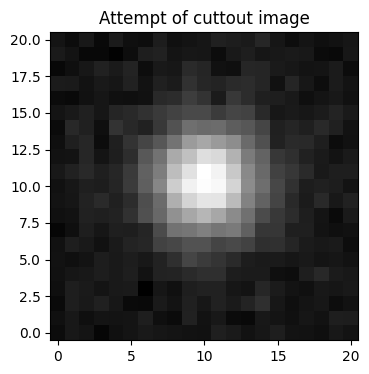

In [22]:
# for j in cutouts:
#     fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))
#     ax1.imshow(j.data, origin='lower', cmap='Greys_r')
#     ax1.set_title('Attempt of cuttout image')

# display just first image
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))
ax1.imshow(cutouts[0].data, origin='lower', cmap='Greys_r')
ax1.set_title('Attempt of cuttout image')

Initial Guesses
Amplitude:            6.386059284210205
Half-light Radius :   1
Sersic Index:         4
Center:               (10.0, 10.0)
Shape of data before model fitting: (21, 21)
Help on Sersic2D in module astropy.modeling.functional_models object:

class Sersic2D(astropy.modeling.core.Fittable2DModel)
 |  Sersic2D(amplitude=1, r_eff=1, n=4, x_0=0, y_0=0, ellip=0, theta=0.0, **kwargs)
 |  
 |  Two dimensional Sersic surface brightness profile.
 |  
 |  Parameters
 |  ----------
 |  amplitude : float
 |      Surface brightness at r_eff.
 |  r_eff : float
 |      Effective (half-light) radius
 |  n : float
 |      Sersic Index.
 |  x_0 : float, optional
 |      x position of the center.
 |  y_0 : float, optional
 |      y position of the center.
 |  ellip : float, optional
 |      Ellipticity.
 |  theta : float or `~astropy.units.Quantity`, optional
 |      The rotation angle as an angular quantity
 |      (`~astropy.units.Quantity` or `~astropy.coordinates.Angle`)
 |      or a valu

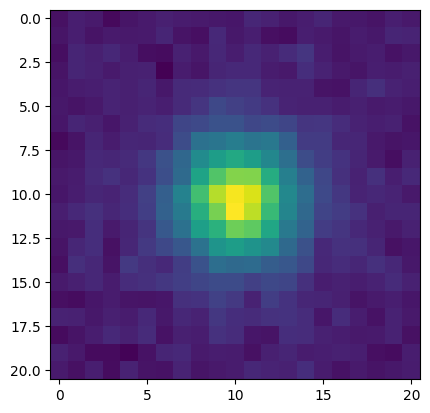

In [59]:
# pass to sersic
# find distribution of sources

# what does it mean to 'fit' an image?
# find a model and adjust its parameters until it is able to quite accurately represent the desired image

from astropy.modeling.models import Sersic2D
spherical_img = cutouts[0]

img_data = spherical_img.data

# Printing Initial Values
print("Initial Guesses")
print(f"Amplitude:            {np.max(img_data)}")
print(f"Half-light Radius :   1")
print(f"Sersic Index:         4")
print(f"Center:               {spherical_img.center_cutout}")


# Model
print(f"Shape of data before model fitting: {spherical_img.data.shape}")

sersic_initial = Sersic2D(amplitude=np.max(img_data), r_eff=1, n=4, x_0=spherical_img.center_cutout[0],y_0=spherical_img.center_cutout[1], ellip=0.1, theta=0)
# help(sersic_initial)

sersic_img = sersic_initial(img_data[0], img_data[1])
print(f"Shape of data after model fitting?: {sersic_img.shape}")
fig, ax = plt.subplots()
ax.imshow(spherical_img.data)
plt.show()